In [5]:
!pip install -q -U transformers==4.37.2
!pip install -q bitsandbytes==0.41.3 accelerate==0.25.0
!pip install -q git+https://github.com/openai/whisper.git
!pip install -q gradio
!pip install -q gTTS

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [6]:
import torch
from transformers import BitsAndBytesConfig, pipeline

In [7]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

In [8]:
model_id = "llava-hf/llava-1.5-7b-hf"

In [9]:
pipe = pipeline("image-to-text",
                model=model_id,
                model_kwargs={"quantization_config": quantization_config})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [10]:
import whisper
import gradio as gr
import time
import warnings
import os
from gtts import gTTS

In [11]:
from PIL import Image

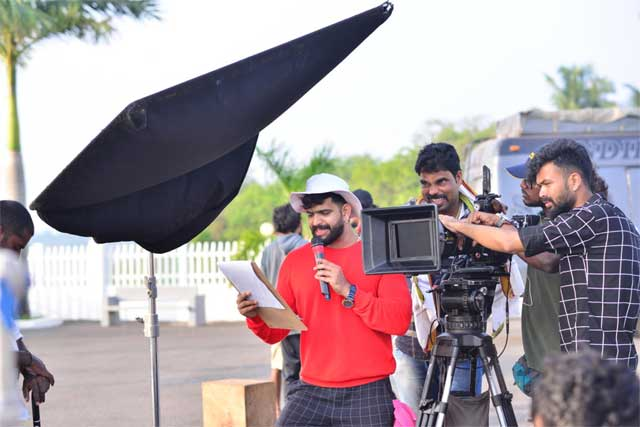

In [12]:
image_path = "img.jpg"
image = Image.open((image_path))
image

In [13]:
import nltk
nltk.download('punkt')
from nltk import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
import locale
print(locale.getlocale())  # Before running the pipeline
# Run the pipeline
print(locale.getlocale())  # After running the pipeline

('en_US', 'UTF-8')
('en_US', 'UTF-8')


In [15]:
max_new_tokens = 200

prompt_instructions = """
Describe the image using as much detail as possible,
is it a painting, a photograph, what colors are predominant,
what is the image about?
"""

prompt = "USER: <image>\n" + prompt_instructions + "\nASSISTANT:"

outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})
# outputs
# print(outputs[0]["generated_text"])
for sent in sent_tokenize(outputs[0]["generated_text"]):
    print(sent)

USER:  

Describe the image using as much detail as possible,
is it a painting, a photograph, what colors are predominant,
what is the image about?
ASSISTANT: The image features a group of people gathered around a man who is holding a microphone.
The man appears to be the center of attention, possibly giving a speech or an interview.
The people surrounding him are engaged in the conversation, with some of them holding cell phones.
The scene takes place outdoors, with a bus visible in the background.
The people in the image are wearing various clothing items, such as a red shirt, a white hat, and a black shirt.
The overall atmosphere of the image suggests a casual and friendly gathering.


In [16]:
warnings.filterwarnings("ignore")

In [17]:
import warnings
from gtts import gTTS
import numpy as np

In [18]:
torch.cuda.is_available()
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using torch {torch.__version__} ({DEVICE})")

Using torch 2.1.0+cu121 (cuda)


In [19]:
import whisper
model = whisper.load_model("medium", device=DEVICE)
print(
    f"Model is {'multilingual' if model.is_multilingual else 'English-only'} "
    f"and has {sum(np.prod(p.shape) for p in model.parameters()):,} parameters."
)

100%|██████████████████████████████████████| 1.42G/1.42G [00:11<00:00, 134MiB/s]


Model is multilingual and has 762,321,920 parameters.


In [20]:
import re

In [22]:
input_text = 'What color is the microphone in image?'
input_image = 'img.jpg'

# load the image
image = Image.open(input_image)

# prompt_instructions = """
# Describe the image using as much detail as possible, is it a painting, a photograph, what colors are predominant, what is the image about?
# """

# print(input_text)
prompt_instructions = """
Act as an expert in imagery descriptive analysis, using as much detail as possible from the image, respond to the following prompt:
""" + input_text
prompt = "USER: <image>\n" + prompt_instructions + "\nASSISTANT:"

# print(prompt)

outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})

match = re.search(r'ASSISTANT:\s*(.*)', outputs[0]["generated_text"])

if match:
    # Extract the text after "ASSISTANT:"
    extracted_text = match.group(1)
    print(extracted_text)
else:
    print("No match found.")

for sent in sent_tokenize(outputs[0]["generated_text"]):
    print(sent)

The microphone in the image is black.
USER:  

Act as an expert in imagery descriptive analysis, using as much detail as possible from the image, respond to the following prompt:
What color is the microphone in image?
ASSISTANT: The microphone in the image is black.


In [23]:
import datetime
import os

In [24]:
## Logger file
tstamp = datetime.datetime.now()
tstamp = str(tstamp).replace(' ','_')
logfile = f'{tstamp}_log.txt'
def writehistory(text):
    with open(logfile, 'a', encoding='utf-8') as f:
        f.write(text)
        f.write('\n')
    f.close()

In [25]:
import re
import requests
from PIL import Image

def img2txt(input_text, input_image):

    # load the image
    image = Image.open(input_image)

    writehistory(f"Input text: {input_text} - Type: {type(input_text)} - Dir: {dir(input_text)}")
    if type(input_text) == tuple:
        prompt_instructions = """
        Describe the image using as much detail as possible, is it a painting, a photograph, what colors are predominant, what is the image about?
        """
    else:
        prompt_instructions = """
        Act as an expert in imagery descriptive analysis, using as much detail as possible from the image, respond to the following prompt:
        """ + input_text

    writehistory(f"prompt_instructions: {prompt_instructions}")
    prompt = "USER: <image>\n" + prompt_instructions + "\nASSISTANT:"

    outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})

    # Properly extract the response text
    if outputs is not None and len(outputs[0]["generated_text"]) > 0:
        match = re.search(r'ASSISTANT:\s*(.*)', outputs[0]["generated_text"])
        if match:
            # Extract the text after "ASSISTANT:"
            reply = match.group(1)
        else:
            reply = "No response found."
    else:
        reply = "No response generated."

    return reply

In [26]:
def transcribe(audio):

    # Check if the audio input is None or empty
    if audio is None or audio == '':
        return ('','',None)  # Return empty strings and None audio file

    # language = 'en'

    audio = whisper.load_audio(audio)
    audio = whisper.pad_or_trim(audio)

    mel = whisper.log_mel_spectrogram(audio).to(model.device)

    _, probs = model.detect_language(mel)

    options = whisper.DecodingOptions()
    result = whisper.decode(model, mel, options)
    result_text = result.text

    return result_text

In [27]:
def text_to_speech(text, file_path):
    language = 'en'

    audioobj = gTTS(text = text,
                    lang = language,
                    slow = False)

    audioobj.save(file_path)

    return file_path

In [29]:
!ffmpeg -f lavfi -i anullsrc=r=44100:cl=mono -t 10 -q:a 9 -acodec libmp3lame Temp.mp3

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [30]:
import gradio as gr
import base64
import os

# A function to handle audio and image inputs
def process_inputs(audio_path, image_path):
    # Process the audio file (assuming this is handled by a function called 'transcribe')
    speech_to_text_output = transcribe(audio_path)

    # Handle the image input
    if image_path:
        chatgpt_output = img2txt(speech_to_text_output, image_path)
    else:
        chatgpt_output = "No image provided."

    # Assuming 'transcribe' also returns the path to a processed audio file
    processed_audio_path = text_to_speech(chatgpt_output, "Temp3.mp3")  # Replace with actual path if different

    return speech_to_text_output, chatgpt_output, processed_audio_path

# Create the interface
iface = gr.Interface(
    fn=process_inputs,
    inputs=[
        gr.Audio(sources=["microphone"], type="filepath"),
        gr.Image(type="filepath")
    ],
    outputs=[
        gr.Textbox(label="Speech to Text"),
        gr.Textbox(label="ChatGPT Output"),
        gr.Audio("Temp.mp3")
    ],
    title="Learn OpenAI Whisper: Image processing with Whisper and Llava",
    description="Upload an image and interact via voice input and audio response."
)

# Launch the interface
iface.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://4c0411a18ed47f14d7.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://4c0411a18ed47f14d7.gradio.live
